In [2]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import signal
from scipy import ndimage
from math import ceil
import cv2
import ot
import itertools

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# PROJECT_PATH = os.getcwd()
sys.path.append(os.path.dirname(PROJECT_PATH))

from _prototypes.cell_remapping.src.remapping import pot_sliced_wasserstein
from _prototypes.cell_remapping.src.wasserstein_distance import _get_ratemap_bucket_midpoints
from library.map_utils import _temp_occupancy_map, _temp_spike_map, _speed2D, _speed_bins, _interpolate_matrix
from core.spatial import Position2D

unit_matcher_path = os.getcwd()
prototype_path = os.path.abspath(os.path.join(unit_matcher_path, os.pardir))
project_path = os.path.abspath(os.path.join(prototype_path, os.pardir))
lab_path = os.path.abspath(os.path.join(project_path, os.pardir))
sys.path.append(project_path)
os.chdir(project_path)
print(project_path)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes


In [4]:
from x_io.rw.axona.batch_read import make_study
from _prototypes.cell_remapping.src.settings import settings_dict


In [14]:
# MEC path

project_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\MEC_GAR"

studies = []
study_folders = []

for folder in os.listdir(project_path):
    settings_dict['smoothing_factor'] = 2
    if 'cell 1' in folder:
        settings_dict['ppm'] = 648
        settings_dict['useMatchedCut'] = False
    elif 'cell 2' in folder:
        settings_dict['ppm'] = 665
        settings_dict['useMatchedCut'] = False

    if 'cell' in folder:

        project_path_use = os.path.join(project_path,folder)

        study = make_study(project_path_use,settings_dict)
        study.make_animals()

        studies.append(study)
        study_folders.append(folder)

SKIPPING, NO FILES FOUND FOR SESSION WITH SIGNATURE: C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\MEC_GAR\cell 1/neurofunc_PRISM_20200819-6-18x18-1000um-Test2_Frontiers/Tetrode
SKIPPING, NO FILES FOUND FOR SESSION WITH SIGNATURE: C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\MEC_GAR\cell 1/neurofunc_PRISM_20200819-6-18x18-1000um-Test1_Frontiers/Tetrode
8 8
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\MEC_GAR\cell 1/20200819-6-18x18-1000um-Test1_8.cut
USING PPM YOU SET IN SETTINGS
PPM HERE:  648
Session animal ID set: cell 1_tet8
8 8
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\MEC_GAR\cell 1/20200819-6-18x18-1000um-Test2_8.cut
USING PPM YOU SET IN SETTINGS
PPM HERE:  648
Session animal ID set: cell 1_tet8
Total spikes:  169074
Matching

In [6]:
studies[0].animals[0].sessions['session_1'].get_spike_data()['spike_cluster'].get_unique_cluster_labels()

array([ 0,  1,  2,  3, 26, 27, 28])

In [9]:
from _prototypes.cell_remapping.src.masks import make_object_ratemap, check_disk_arena, flat_disk_mask, generate_grid, _sample_grid
from library.hafting_spatial_maps import SpatialSpikeTrain2D
from library.maps import map_blobs
from library.scores import hd_score, grid_score, border_score
from library.scores import rate_map_stats, rate_map_coherence, speed_score

def scale_points(pts):
    # Separate the x and y coordinates
    curr_spike_pos_x = pts[:, 0]
    curr_spike_pos_y = pts[:, 1]

    # Compute the minimum and maximum values for x and y coordinates
    min_x = np.min(curr_spike_pos_x)
    max_x = np.max(curr_spike_pos_x)
    min_y = np.min(curr_spike_pos_y)
    max_y = np.max(curr_spike_pos_y)

    # Perform Min-Max scaling separately for x and y coordinates
    scaled_x = (curr_spike_pos_x - min_x) / (max_x - min_x)
    scaled_y = (curr_spike_pos_y - min_y) / (max_y - min_y)

    # Combine the scaled x and y coordinates
    scaled_pts = np.column_stack((scaled_x, scaled_y))

    return scaled_pts

gar_cell_dict = {}
blobs_cell_dict = {}
scores_cell_dict = {}
func_scores_dict = {}

for study in studies:
    for animal in study.animals:
        try:
            max_matched_cell_count = max(list(map(lambda x: max(animal.sessions[x].get_cell_data()['cell_ensemble'].get_label_ids()), animal.sessions)))
        except:
            max_matched_cell_count = 0
            for x in animal.sessions:
                cell_label_ids = animal.sessions[x].get_cell_data()['cell_ensemble'].get_label_ids() 
                nmb_matched = len(cell_label_ids)
                if nmb_matched > max_matched_cell_count:
                    max_matched_cell_count = nmb_matched
        for k in range(int(max_matched_cell_count)):
            cell_label = k + 1
            prev = None
            for i in range(len(list(animal.sessions.keys()))):
                seskey = 'session_' + str(i+1)
                ses = animal.sessions[seskey]
                path = ses.session_metadata.file_paths['tet']
                fname = path.split('/')[-1].split('.')[0]
                ensemble = animal.sessions[seskey].get_cell_data()['cell_ensemble']

                if cell_label in ensemble.get_cell_label_dict():
                    cell = ensemble.get_cell_by_id(cell_label)
                    
                    pos_obj = ses.get_position_data()['position']
                    spatial_spike_train = ses.make_class(SpatialSpikeTrain2D, {'cell': cell, 'position': pos_obj})

                    rate_map_obj = spatial_spike_train.get_map('rate')

                    rate_map, _ = rate_map_obj.get_rate_map(new_size = 32)

                    if 'cylinder' in fname.lower():
                        cylinder = True
                    else:
                        cylinder = False

                    image, n_labels, labels, centroids, field_sizes = map_blobs(spatial_spike_train, ratemap_size=32, cylinder=cylinder, 
                                                                                downsample=False, downsample_factor=None)
                    
                    # Disk mask ratemap
                    if cylinder:
                        curr = flat_disk_mask(rate_map)
                        curr_ratemap = curr
                        row, col = np.where(~np.isnan(curr_ratemap))
                        disk_ids = np.array([row, col]).T
                    else:
                        curr = rate_map
                        curr_ratemap = curr
                        disk_ids = None
                    gscore = grid_score(spatial_spike_train)
                    bscore = border_score(spatial_spike_train)
                    ratemap_stats_dict = rate_map_stats(spatial_spike_train)
                    si_score = ratemap_stats_dict['spatial_information_content']
                    if prev is not None:
                        prev_ratemap = prev
                        curr_spatial_spike_train = spatial_spike_train
                        y, x = prev_ratemap.shape
                        # prev_spike_pos_x, prev_spike_pos_y, prev_spike_pos_t = prev_spatial_spike_train.spike_x, prev_spatial_spike_train.spike_y, prev_spatial_spike_train.new_spike_times
                        # prev_pts = np.array([prev_spike_pos_x, prev_spike_pos_y])
                        # curr_spike_pos_x, curr_spike_pos_y, curr_spike_pos_t = curr_spatial_spike_train.spike_x, curr_spatial_spike_train.spike_y, curr_spatial_spike_train.new_spike_times
                        # curr_pts = np.array([curr_spike_pos_x, curr_spike_pos_y]).T
                        # find indices of not nan 
                        row_prev, col_prev = np.where(~np.isnan(prev_ratemap))
                        row_curr, col_curr = np.where(~np.isnan(curr_ratemap))

                        prev_height_bucket_midpoints, prev_width_bucket_midpoints = _get_ratemap_bucket_midpoints(prev_spatial_spike_train.arena_size, y, x)
                        curr_height_bucket_midpoints, curr_width_bucket_midpoints = _get_ratemap_bucket_midpoints(curr_spatial_spike_train.arena_size, y, x)
                                    
                        prev_height_bucket_midpoints = prev_height_bucket_midpoints[row_prev]
                        prev_width_bucket_midpoints = prev_width_bucket_midpoints[col_prev]
                        curr_height_bucket_midpoints = curr_height_bucket_midpoints[row_curr]
                        curr_width_bucket_midpoints = curr_width_bucket_midpoints[col_curr]
                        source_weights = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_prev, col_prev)))
                        target_weights = np.array(list(map(lambda x, y: curr_ratemap[x,y], row_curr, col_curr)))
                        source_weights = source_weights / np.sum(source_weights)
                        target_weights = target_weights / np.sum(target_weights)
                        coord_buckets_curr = np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr, col_curr)))
                        coord_buckets_prev = np.array(list(map(lambda x, y: [prev_height_bucket_midpoints[x],prev_width_bucket_midpoints[y]], row_prev, col_prev)))

                        # curr_pts = scale_points(curr_pts)
                        # prev_pts = scale_points(prev_pts)
                        # spike_dens_wass = pot_sliced_wasserstein(prev_pts, curr_pts, n_projections=10**3)
                        wass = pot_sliced_wasserstein(coord_buckets_prev, coord_buckets_curr, source_weights, target_weights, n_projections=10**3)
                        corr = pearsonr(source_weights, target_weights)[0]

                        wass_shifts = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        corr_shifts = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        wass_shifts_wrap = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        corr_shifts_wrap = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        wass_shifts_center = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        corr_shifts_center = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        wass_shifts_center_wrap = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        corr_shifts_center_wrap = np.zeros((prev_ratemap.shape[0], prev_ratemap.shape[1]))
                        print('looping')
                        for i in range(prev_ratemap.shape[0]):
                            for j in range(prev_ratemap.shape[1]):
                                shift = (i, j)
                                # # shift with nan
                                
                                wrap_map = np.roll(curr_ratemap, shift=shift, axis=(0, 1))
                                shift_center = (i - int(np.floor(prev_ratemap.shape[0] / 2)), j - int(np.floor(prev_ratemap.shape[1] / 2)))
                                wrap_map_center = np.roll(curr_ratemap, shift=shift_center, axis=(0, 1))
                                # midp = int(np.floor(prev_ratemap.shape[0] / 2))
                                # shift = (midp - i, midp - j)
                                shifted_map = sio.ndimage.shift(curr_ratemap, shift, mode='constant', cval=0)
                                shifted_map_center = sio.ndimage.shift(curr_ratemap, shift_center, mode='constant', cval=0)
                                row_curr, col_curr = np.where(~np.isnan(shifted_map))
                                curr_height_bucket_midpoints, curr_width_bucket_midpoints = _get_ratemap_bucket_midpoints(curr_spatial_spike_train.arena_size, y, x)
                                curr_height_bucket_midpoints = curr_height_bucket_midpoints[row_curr]
                                curr_width_bucket_midpoints = curr_width_bucket_midpoints[col_curr]
                                target_weights = np.array(list(map(lambda x, y: shifted_map[x,y], row_curr, col_curr)))
                                target_weights_wrap = np.array(list(map(lambda x, y: wrap_map[x,y], row_curr, col_curr)))
                                target_weights_center = np.array(list(map(lambda x, y: shifted_map_center[x,y], row_curr, col_curr)))
                                target_weights_wrap_center = np.array(list(map(lambda x, y: wrap_map_center[x,y], row_curr, col_curr)))
                                source_weights_pearson = np.array(list(map(lambda x, y: prev_ratemap[x,y], row_curr, col_curr)))
                                target_weights = target_weights / np.sum(target_weights)
                                target_weights_wrap = target_weights_wrap / np.sum(target_weights_wrap)
                                target_weights_center = target_weights_center / np.sum(target_weights_center)
                                target_weights_wrap_center = target_weights_wrap_center / np.sum(target_weights_wrap_center)
                                source_weights_pearson = source_weights_pearson / np.sum(source_weights_pearson)

                                wass_shift = pot_sliced_wasserstein(coord_buckets_prev, np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr, col_curr))), source_weights, target_weights, n_projections=10**3)
                                corr_shift = pearsonr(source_weights_pearson, target_weights)[0]
                                wass_wrap = pot_sliced_wasserstein(coord_buckets_prev, np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr, col_curr))), source_weights, target_weights_wrap, n_projections=10**3)
                                corr_wrap = pearsonr(source_weights_pearson, target_weights_wrap)[0]
                                wass_shift_center = pot_sliced_wasserstein(coord_buckets_prev, np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr, col_curr))), source_weights, target_weights_center, n_projections=10**3)
                                corr_shift_center = pearsonr(source_weights_pearson, target_weights_center)[0]
                                wass_wrap_center = pot_sliced_wasserstein(coord_buckets_prev, np.array(list(map(lambda x, y: [curr_height_bucket_midpoints[x],curr_width_bucket_midpoints[y]], row_curr, col_curr))), source_weights, target_weights_wrap_center, n_projections=10**3)
                                corr_wrap_center = pearsonr(source_weights_pearson, target_weights_wrap_center)[0]
                        
                                wass_shifts[i, j] = wass_shift
                                corr_shifts[i, j] = corr_shift
                                wass_shifts_wrap[i, j] = wass_wrap
                                corr_shifts_wrap[i, j] = corr_wrap
                                wass_shifts_center[i, j] = wass_shift_center
                                corr_shifts_center[i, j] = corr_shift_center
                                wass_shifts_center_wrap[i, j] = wass_wrap_center
                                corr_shifts_center_wrap[i, j] = corr_wrap_center
  
                                # corr_shifts_center_wrap[shift_center[0], shift_center[1]] = corr_wrap_center
                            
                    title = animal.animal_id.split(' ')[0] + animal.animal_id.split(' ')[1] + '_' + seskey.replace('_', '') + '_' + str(cell_label)

                    gar_cell_dict[title] = curr_ratemap
                    blobs_cell_dict[title] = [labels, centroids]
                    if prev is not None:
                        scores_cell_dict[title] = [wass, corr, wass_shifts, corr_shifts, wass_shifts_wrap, corr_shifts_wrap,
                                                    wass_shifts_center, corr_shifts_center, wass_shifts_center_wrap, corr_shifts_center_wrap]

                    func_scores_dict[title] = [gscore, bscore, si_score]

                    prev = curr_ratemap
                    prev_spatial_spike_train = spatial_spike_train

                

Using speed bounds 0 to 100
computing rate map bcs map_data is None
getting occ map
getting spike map
Computing rate map
using existing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 32
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
Using speed bounds 0 to 100
computing rate map bcs map_data is None
getting occ map
getting spike map
Computing rate map
using existing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 32
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_size None != self.map_data.shape[0] 64
Computing rate map
computing rate map bcs new_siz

In [10]:
gar_cell_dict.keys()

dict_keys(['cell1_tet8_session1_1', 'cell1_tet8_session2_1', 'cell1_tet8_session1_2', 'cell1_tet8_session2_2', 'cell1_tet8_session1_3', 'cell1_tet8_session2_3', 'cell2_tet4_session1_1', 'cell2_tet4_session2_1', 'cell2_tet4_session1_2', 'cell2_tet4_session2_2', 'cell2_tet4_session2_3'])

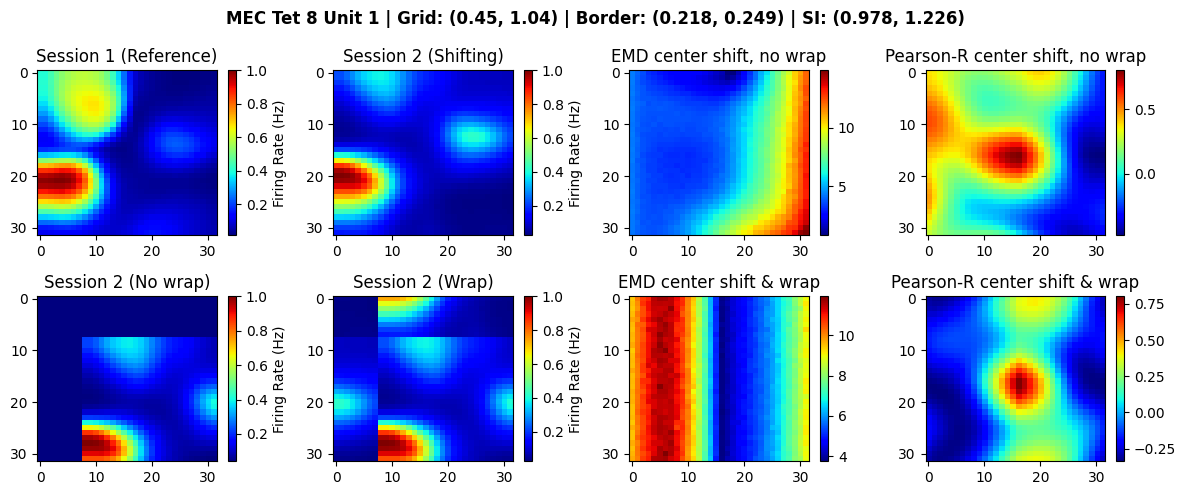

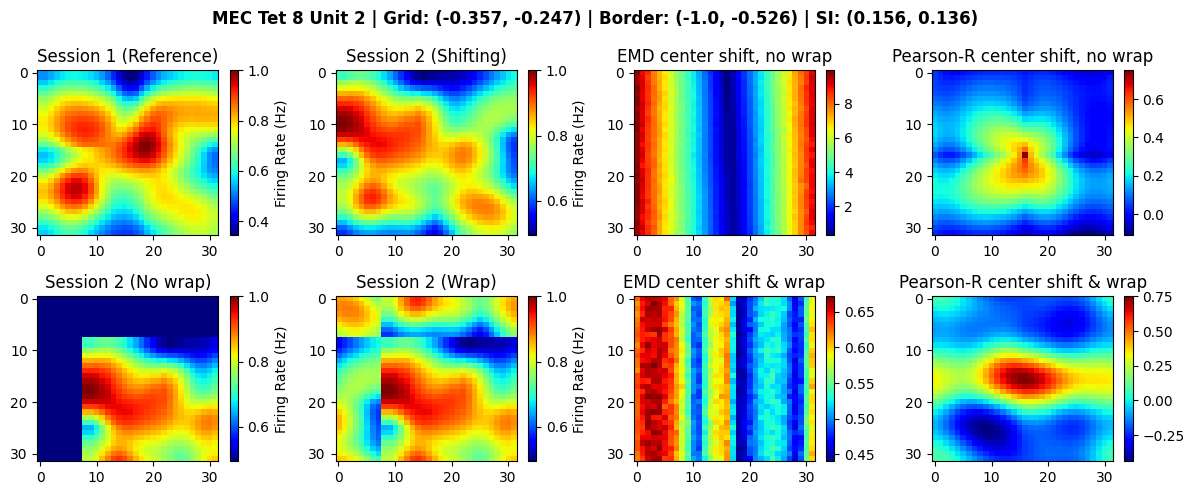

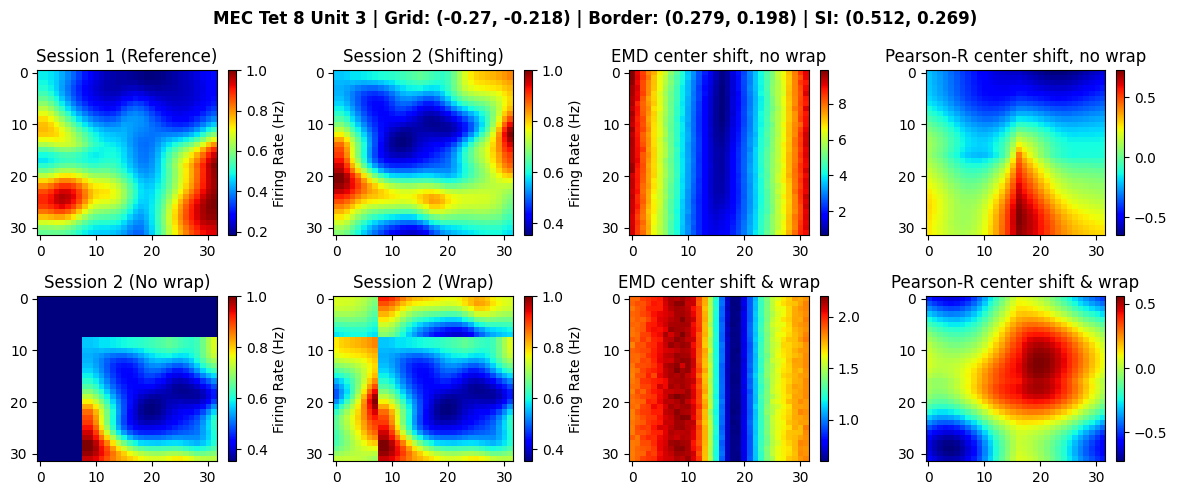

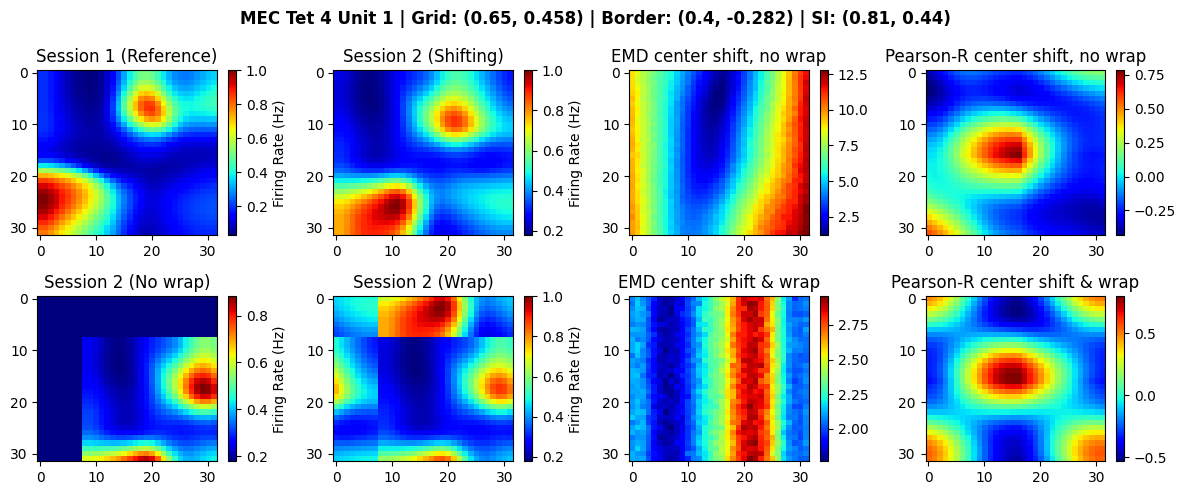

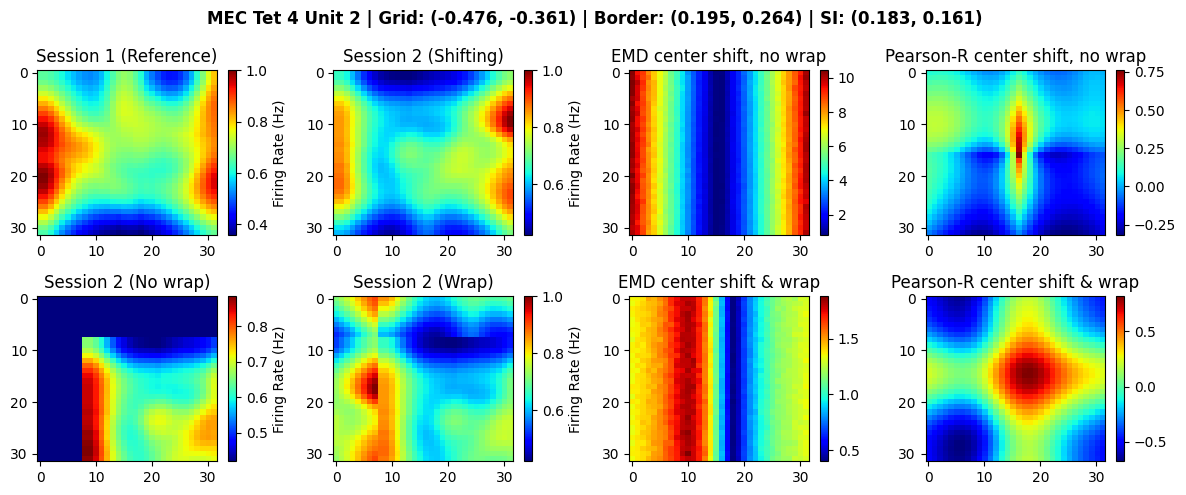

In [27]:
import scipy as sio

c1u1ky = ['cell1_tet8_session1_1', 'cell1_tet8_session2_1']
c1u2ky = ['cell1_tet8_session1_2', 'cell1_tet8_session2_2']
c1u3ky = ['cell1_tet8_session1_3', 'cell1_tet8_session2_3']

c2u1ky = ['cell2_tet4_session1_1', 'cell2_tet4_session2_1']
c2u2ky = ['cell2_tet4_session1_2', 'cell2_tet4_session2_2']

c1u1 = [gar_cell_dict[x] for x in c1u1ky]
c1u2 = [gar_cell_dict[x] for x in c1u2ky]
c1u3 = [gar_cell_dict[x] for x in c1u3ky]

c2u1 = [gar_cell_dict[x] for x in c2u1ky]
c2u2 = [gar_cell_dict[x] for x in c2u2ky]

units = [c1u1, c1u2, c1u3, c2u1, c2u2]
unit_keys = [c1u1ky, c1u2ky, c1u3ky, c2u1ky, c2u2ky]
unit_titles = ['MEC Tet 8 Unit 1', 'MEC Tet 8 Unit 2', 'MEC Tet 8 Unit 3', 'MEC Tet 4 Unit 1', 'MEC Tet 4 Unit 2']

for i in range(len(units)):
    unit = units[i]
    unit_title = unit_titles[i]
    wass, corr, wass_shifts, corr_shifts, wass_shifts_wrap, corr_shifts_wrap, wass_shifts_center, corr_shifts_center, wass_shifts_center_wrap, corr_shifts_center_wrap = scores_cell_dict[unit_keys[i][1]]
    prev_gscore, prev_bscore, prev_si_score = func_scores_dict[unit_keys[i][0]]
    curr_gscore, curr_bscore, curr_si_score = func_scores_dict[unit_keys[i][1]]

    fig = plt.figure(figsize=(12,5))

    toplot = unit[0]

    ax = fig.add_subplot(2,4,1)
    img = ax.imshow(toplot, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    cbar.ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Session 1 (Reference)')

    toplot = unit[1]
    toplot_copy = sio.ndimage.shift(toplot, (8, 8), mode='constant', cval=np.nan)
    toplot = sio.ndimage.shift(toplot, (8, 8), mode='constant', cval=np.nan)
    ax = fig.add_subplot(2,4,5)
    img = ax.imshow(toplot, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    cbar.ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Session 2 (No wrap)')
    not_nan = ~np.isnan(toplot_copy)
    is_nan = np.isnan(toplot_copy)
    toplot_copy[is_nan] = 0
    toplot_copy[not_nan] = np.nan
    ax.imshow(toplot_copy, cmap='jet', aspect='auto')


    toplot = unit[1]
    toplot = np.roll(toplot, shift=(8, 8), axis=(0, 1))
    ax = fig.add_subplot(2,4,6)
    img = ax.imshow(toplot, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    cbar.ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Session 2 (Wrap)')

    ax = fig.add_subplot(2,4,2)
    img = ax.imshow(unit[1], cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    cbar.ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Session 2 (Shifting)')

    # ax = fig.add_subplot(2,6,5)
    # img = ax.imshow(wass_shifts, cmap='jet', aspect='auto')
    # cbar = fig.colorbar(img, ax=ax)
    # # cbar.ax.set_ylabel('')
    # ax.set_title('EMD corner shift, no wrap')

    ax = fig.add_subplot(2,4,3)
    img = ax.imshow(wass_shifts_center, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    # cbar.ax.set_ylabel('')
    ax.set_title('EMD center shift, no wrap')

    # ax = fig.add_subplot(2,6,6)
    # img = ax.imshow(corr_shifts, cmap='jet', aspect='auto')
    # cbar = fig.colorbar(img, ax=ax)
    # # cbar.ax.set_ylabel('Correlation')
    # ax.set_title('Pearson-R corner shift, no wrap')

    ax = fig.add_subplot(2,4,4)
    img = ax.imshow(corr_shifts_center, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    # cbar.ax.set_ylabel('Correlation')
    ax.set_title('Pearson-R center shift, no wrap')

    # ax = fig.add_subplot(2,6,11)
    # img = ax.imshow(wass_shifts_wrap, cmap='jet', aspect='auto')
    # cbar = fig.colorbar(img, ax=ax)
    # # cbar.ax.set_ylabel('')
    # ax.set_title('EMD corner shift & wrap')

    ax = fig.add_subplot(2,4,7)
    img = ax.imshow(wass_shifts_center_wrap, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    # cbar.ax.set_ylabel('')
    ax.set_title('EMD center shift & wrap')

    # ax = fig.add_subplot(2,6,12)
    # img = ax.imshow(corr_shifts_wrap, cmap='jet', aspect='auto')
    # cbar = fig.colorbar(img, ax=ax)
    # # cbar.ax.set_ylabel('Correlation')
    # ax.set_title('Pearson-R corner shift & wrap')

    ax = fig.add_subplot(2,4,8)
    img = ax.imshow(corr_shifts_center_wrap, cmap='jet', aspect='auto')
    cbar = fig.colorbar(img, ax=ax)
    # cbar.ax.set_ylabel('Correlation')
    ax.set_title('Pearson-R center shift & wrap')

    fig.suptitle(unit_title + ' | Grid: (' + str(round(prev_gscore, 3)) + ', ' + str(round(curr_gscore, 3)) + 
                 ') | Border: (' + str(round(max(prev_bscore), 3)) + ', ' + str(round(max(curr_bscore), 3)) + 
                 ') | SI: (' + str(round(prev_si_score, 3)) + ', ' + str(round(curr_si_score, 3)) + ')',
                    fontsize=12, fontweight='bold')
    
    # fig.suptitle(unit_title + ' | Grid: ' + str(round(gscore, 3)) + ' | Border: ' + str(round(max(bscore), 3)) + ' | SI: ' + str(round(si_score, 3)))
    #' | Wass: ' + str(round(wass, 3)) + ' | Corr: ' + str(round(corr, 3)) + 
    fig.tight_layout()
    plt.show()



In [12]:
scores_cell_dict

{'cell1_tet8_session2_1': [3.8532615778734702,
  0.8026772800564846,
  array([[ 3.87600064,  4.19385588,  4.62913373, ..., 23.38661356,
          23.36894744, 24.11257532],
         [ 3.83361273,  4.27582765,  4.67860446, ..., 23.40094119,
          23.83436425, 24.04756364],
         [ 3.92522812,  4.32829664,  4.6512993 , ..., 22.97037132,
          23.94534267, 24.42250442],
         ...,
         [ 2.71396918,  3.49438626,  4.21413837, ..., 23.05114153,
          23.89638164, 24.31226413],
         [ 2.72685793,  3.48661717,  4.2139921 , ..., 23.22310684,
          23.2654746 , 24.53395161],
         [ 2.8019116 ,  3.47063322,  4.28018687, ..., 23.17920611,
          23.30631345, 24.37482262]]),
  array([[ 0.80267728,  0.7313886 ,  0.64440106, ..., -0.18823327,
          -0.15391714, -0.1089883 ],
         [ 0.78629064,  0.71812837,  0.63447021, ..., -0.18768726,
          -0.15327618, -0.10842466],
         [ 0.73225222,  0.66927774,  0.59148505, ..., -0.18490106,
          -0.150